# Boli perturb ctx edit ntsubset hvg

In [1]:
import scanpy as sc
boli_perturb_ctx = sc.read_h5ad("/gpfs/home/asun/jin_lab/database/boli_perturb_ctx_edit_ntsubset_hvg/processed/gloria/adata.h5ad")


In [2]:
boli_perturb_ctx.obs["Assign"].value_counts()

Assign
Bcl11b_0    5367
Trio_0      4274
Dab1_0      4123
Tbr1_0      3466
NT_0        2735
Rb1cc1_0    2534
Satb2_0     2320
Herc1_0     2165
Ank3_0      1763
Xpo7_0      1602
Cx3cl1_0    1392
Cul1_0      1297
Name: count, dtype: int64

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import sys
import anndata

# Add systema evaluation to path
sys.path.append('/gpfs/home/juntongy/gloria/systema/systema/evaluation')
from evaluation.eval_utils import compute_shift_similarities

sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 100

### Copy `compute_shift_similarities` function from `eval_util.py`

- perturbation cells (control == 0) and control cells (control == 1)
- Computes perturbation shifts using two references:
- 'avg_ctl': each perturbation centroid minus control mean
- 'avg_pert': each perturbation centroid minus perturbation mean

In [5]:
def pre_process(raw, dataset_name):
    adata = raw.copy()
    
    # Set condition column from Assign
    if "Assign" in adata.obs.columns:
        adata.obs["condition"] = adata.obs["Assign"]
    elif "condition" not in adata.obs.columns:
        raise ValueError("Could not find 'Assign' or 'condition' column.")

    control_mean = None 
    # Find control cells
    if "Assign" in adata.obs.columns:
        control_mask = adata.obs["Assign"].str.contains("NT_0", case=False, na=False)
    else:
        control_mask = adata.obs["condition"].astype(str).str.contains("NT_0", case=False, na=False)
    
    # Set control column (0 = perturbation, 1 = control)
    adata.obs["control"] = control_mask.astype(int)

    # Compute control mean
    if control_mask.sum() > 0:
        control_mean = np.array(adata[control_mask].X.mean(axis=0)).ravel()
    print(control_mean)
    print(adata.obs['control'].value_counts())

    df, df_pair, df_norm, pert_names = compute_shift_similarities(adata, control_mean=control_mean)
    for _df in (df, df_pair, df_norm):
        _df["dataset"] = dataset_name
    print("df:", df.shape, "df_pair:", df_pair.shape, "df_norm:", df_norm.shape, "#perts:", len(pert_names))
    print(df.groupby("variable")["value"].describe())

    return df, df_pair, df_norm, pert_names

In [6]:
def plot_systematic_variation(df, dataset_name, pert_names):
    fontsize = 18

    # For single dataset, create a simpler violin plot
    plt.figure(figsize=(6, 5))

    # Create the violin plot
    sns.violinplot(
        data=df,
        x='dataset',
        y='value',
        hue='variable',
        split=True,
        inner="quart",
        gap=.2,
        ax=plt.gca(),
        palette="Greens",
        cut=0
    )

    # Customize the plot
    plt.title('Systematic Variation', fontsize=fontsize)
    plt.ylabel('Cosine Similarity', fontsize=fontsize)
    plt.xlabel('')
    plt.xticks([])  # Remove x-axis ticks since we only have one dataset
    plt.yticks(fontsize=fontsize)
    plt.grid(axis='y', linestyle='dotted')

    # Customize legend
    handles, labels = plt.gca().get_legend_handles_labels()

    plt.tight_layout()
    plt.show()

In [7]:
df, df_pair, df_norm, pert_names = pre_process(boli_perturb_ctx, "boli_perturb_ctx_edit_ntsubset_hvg")
dataset_name = "boli_perturb_ctx_edit_ntsubset_hvg"

[1.8995616  0.05877268 0.04348582 ... 0.         0.         0.49551803]
control
0    30303
1     2735
Name: count, dtype: int64
df: (22, 4) df_pair: (110, 3) df_norm: (22, 4) #perts: 11
          count      mean       std       min       25%       50%       75%  \
variable                                                                      
avg_ctl    11.0  0.553383  0.120601  0.303203  0.462432  0.624659  0.642015   
avg_pert   11.0 -0.072062  0.241109 -0.490421 -0.215961 -0.056119  0.113952   

               max  
variable            
avg_ctl   0.656246  
avg_pert  0.225568  


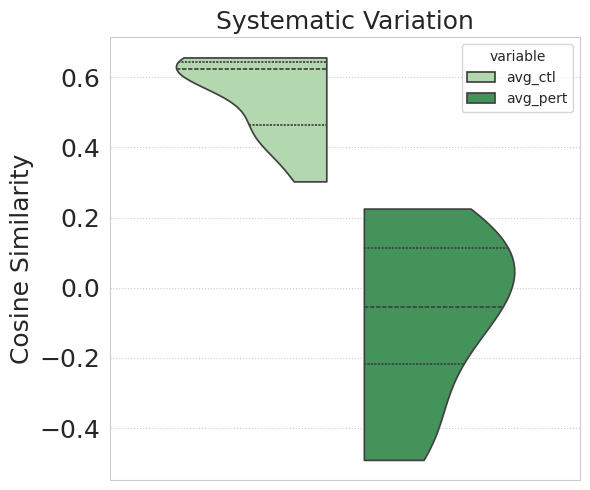

In [8]:
plot_systematic_variation(df, dataset_name, pert_names)

In [9]:
def print_systematic_variation_summary(df, df_pair, dataset_name, pert_names):

    print("=" * 80)
    print("SYSTEMATIC VARIATION SUMMARY")
    print("=" * 80)

    print(f"\nDataset: {dataset_name}")
    print(f"Number of perturbations: {len(pert_names)}")

    print(f"\n Summary by Reference Type:")
    summary = df.groupby('variable')['value'].agg(['mean', 'std', 'count', 'min', 'max'])
    for ref_type in summary.index:
        mean_val = summary.loc[ref_type, 'mean']
        std_val = summary.loc[ref_type, 'std']
        print(f"\n  {ref_type}:")
        print(f"    Mean:   {mean_val:.4f} ± {std_val:.4f}")
        print(f"    Range:  [{summary.loc[ref_type, 'min']:.4f}, {summary.loc[ref_type, 'max']:.4f}]")
        print(f"    Count:  {summary.loc[ref_type, 'count']}")

    # Show pairwise similarities if available
    if len(df_pair) > 0:
        print(f"\n Pairwise Similarities:")
        print(f"  Total pairs: {len(df_pair)}")
        if 'variable' in df_pair.columns:
            for var in df_pair['variable'].unique():
                subset = df_pair[df_pair['variable'] == var]
                print(f"  {var}: {subset['value'].mean():.4f} ± {subset['value'].std():.4f}")

    print("\n" + "=" * 80)

# Call the function
print_systematic_variation_summary(df, df_pair, dataset_name, pert_names)

SYSTEMATIC VARIATION SUMMARY

Dataset: boli_perturb_ctx_edit_ntsubset_hvg
Number of perturbations: 11

 Summary by Reference Type:

  avg_ctl:
    Mean:   0.5534 ± 0.1206
    Range:  [0.3032, 0.6562]
    Count:  11

  avg_pert:
    Mean:   -0.0721 ± 0.2411
    Range:  [-0.4904, 0.2256]
    Count:  11

 Pairwise Similarities:
  Total pairs: 110
  avg_ctl: 0.2592 ± 0.1831
  avg_pert: -0.0571 ± 0.2028



# boli_morphology_raw

In [10]:
boli_morphology = sc.read_h5ad("/gpfs/home/asun/jin_lab/database/boli_morphology/raw/adata.h5ad")

KeyboardInterrupt: 

In [ ]:
boli_morphology.obs.columns


Index(['orig.ident', 'nCount_RNA', 'nFeature_RNA', 'RNA_snn_res.0.8',
       'seurat_clusters', 'Assign', 'Sample', 'scds', 'cxds', 'bcds',
       'nCount_refAssay', 'nFeature_refAssay', 'predicted.subclass.score',
       'predicted.subclass', 'RNA_snn_res.1.5', 'CT', 'mito', 'CT2', 'Top',
       'ident'],
      dtype='object')

In [ ]:
df, df_pair, df_norm, pert_names = pre_process(boli_morphology, "boli_morphology")
dataset_name = "boli_morphology"


[10.3125    0.078125  0.15625  ...  0.        0.        1.78125 ]
control
0    54824
1       64
Name: count, dtype: int64
df: (34, 4) df_pair: (272, 3) df_norm: (34, 4) #perts: 17
          count      mean       std       min       25%       50%       75%  \
variable                                                                      
avg_ctl    17.0  0.960445  0.043155  0.823721  0.941206  0.971316  0.993526   
avg_pert   17.0 -0.049408  0.673874 -0.944225 -0.735385  0.043861  0.632232   

               max  
variable            
avg_ctl   0.997076  
avg_pert  0.818529  


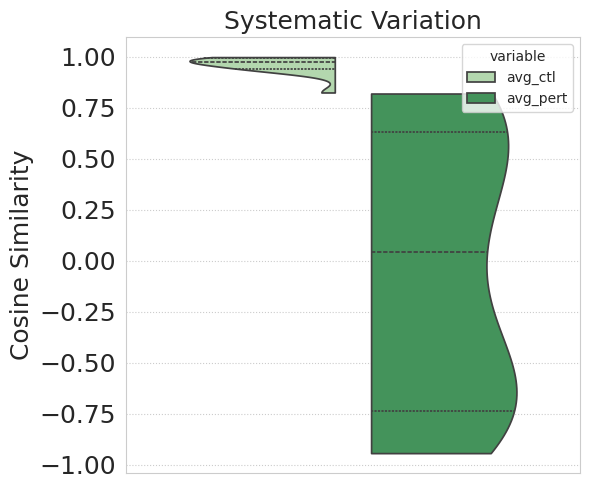

In [ ]:
plot_systematic_variation(df, dataset_name, pert_names)

In [ ]:
print_systematic_variation_summary(df, df_pair, dataset_name, pert_names)

SYSTEMATIC VARIATION SUMMARY

Dataset: boli_morphology
Number of perturbations: 17

 Summary by Reference Type:

  avg_ctl:
    Mean:   0.9604 ± 0.0432
    Range:  [0.8237, 0.9971]
    Count:  17

  avg_pert:
    Mean:   -0.0494 ± 0.6739
    Range:  [-0.9442, 0.8185]
    Count:  17

 Pairwise Similarities:
  Total pairs: 272
  avg_ctl: 0.9198 ± 0.0840
  avg_pert: 0.0348 ± 0.5746



# boli_morphology_processed

In [ ]:
boli_morphology_processed = sc.read_h5ad("/gpfs/home/asun/jin_lab/database/boli_morphology/processed/gloria/adata.h5ad")

In [ ]:
boli_morphology_processed.obs['Assign'].value_counts()


Assign
Grin2b_1     13510
Cux2_0        7231
Kmt5b_0       5899
Shank3_0      3997
NT_2          3262
Pogz_1        3096
Adnp_1        2939
ST_2          2921
Med13L_0      2920
ST_1          1955
Foxp1_1       1858
Syngap1_1     1746
Arid1b_0      1157
ST_0           876
Cux2_1         672
NT_1           549
Grin2b_0       236
NT_0            64
Name: count, dtype: int64

In [ ]:
df, df_pair, df_norm, pert_names = pre_process(boli_morphology_processed, "boli_morphology_processed")
dataset_name = "boli_morphology_processed"


[1.89681482 0.03587264 0.08738338 ... 0.         0.         0.69225361]
control
0    54824
1       64
Name: count, dtype: int64
df: (34, 4) df_pair: (272, 3) df_norm: (34, 4) #perts: 17
          count      mean       std       min       25%       50%       75%  \
variable                                                                      
avg_ctl    17.0  0.949089  0.043531  0.848415  0.946855  0.967268  0.982277   
avg_pert   17.0 -0.001025  0.298691 -0.424102 -0.210790 -0.048643  0.202698   

               max  
variable            
avg_ctl   0.988594  
avg_pert  0.573527  


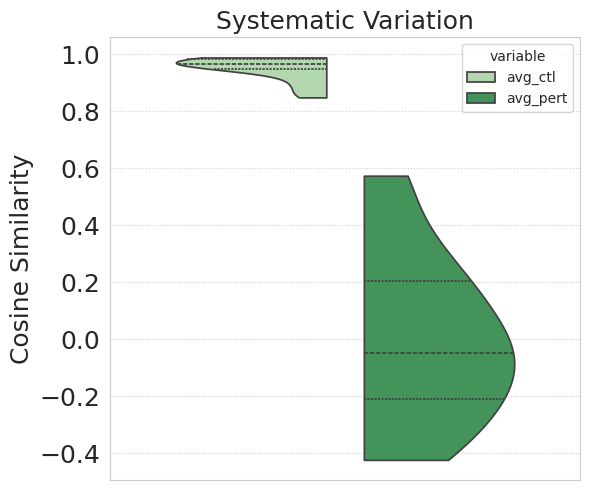

In [ ]:
plot_systematic_variation(df, dataset_name, pert_names)

In [ ]:
print_systematic_variation_summary(df, df_pair, dataset_name, pert_names)

SYSTEMATIC VARIATION SUMMARY

Dataset: boli_morphology_processed
Number of perturbations: 17

 Summary by Reference Type:

  avg_ctl:
    Mean:   0.9491 ± 0.0435
    Range:  [0.8484, 0.9886]
    Count:  17

  avg_pert:
    Mean:   -0.0010 ± 0.2987
    Range:  [-0.4241, 0.5735]
    Count:  17

 Pairwise Similarities:
  Total pairs: 272
  avg_ctl: 0.8948 ± 0.0678
  avg_pert: -0.0469 ± 0.2842



In [ ]:
df_norm.sort_values('value').head()


,pert_names,variable,value,dataset
31,ST_2,avg_pert,0.928741,boli_morphology_processed
27,NT_2,avg_pert,0.938636,boli_morphology_processed
32,Shank3_0,avg_pert,1.017154,boli_morphology_processed
30,ST_1,avg_pert,1.018765,boli_morphology_processed
28,Pogz_1,avg_pert,1.167036,boli_morphology_processed


In [ ]:
pert_names

['Adnp_1',
 'Arid1b_0',
 'Cux2_0',
 'Cux2_1',
 'Foxp1_1',
 'Grin2b_0',
 'Grin2b_1',
 'Kmt5b_0',
 'Med13L_0',
 'NT_1',
 'NT_2',
 'Pogz_1',
 'ST_0',
 'ST_1',
 'ST_2',
 'Shank3_0',
 'Syngap1_1']